# Import packages and libraries

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# Set the grid

In [3]:
# iB = 6

path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [4]:
# read one basin or whole ASTE
whole = True
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = mymsk <=8
    #mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [5]:
# test1 = test.copy()

# Load the files

We want the volume transport in and out of the Arctic and to bin this in T-S space, also salt tend and heat tend so we can do arrows

In [6]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.array([3,4,9,10])   # load four so we can do tendency of two month periods
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [7]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [8]:
# get velocity fields - we actually need this for the total transport pcolormesh
# read timesteps at index 1 and 3
UVELMASS = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
VVELMASS = np.full((int(len(tsstr)),nz,ny,nx),np.nan)

# read the averages from tsstr[1] and tsstr[3] - averages from March and September
# start from 1 because these are averages
for i in range(0,len(tsstr)-1):

    meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[i+1] + '.meta')
    fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
    varnames = np.array(['UVELMASS','VVELMASS','ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH','ADVx_SLT','ADVy_SLT','DFxE_SLT','DFyE_SLT'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    UVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[0])     # m/s
    VVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[1])     # m/s=
    
    # reshaping and fixing up
    UVELMASS[i,:,:,:] = UVELMASSi.reshape(nz,ny,nx)
    VVELMASS[i,:,:,:] = VVELMASSi.reshape(nz,ny,nx)

# get the vectors of u and v without mass weighting
Uo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
Vo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)

for i in range((int(len(tsstr)))):
    # get values from reading before
    tmpU = UVELMASS[i]
    tmpV = VVELMASS[i]

    # define u and v velocities
    tmpUo,tmpVo = get_aste_vector_face1_3(tmpU,tmpV,nfx,nfy,False)
    tmpUo,tmpVo = tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1]     # centering

    # add to larger arrays
    Uo[i] = tmpUo
    Vo[i] = tmpVo

In [9]:
# do salt tendency
# Initialize the new array with the desired shape (2, z, y, x)
dSALTDRdt = np.zeros((2, SALTDR.shape[1], SALTDR.shape[2], SALTDR.shape[3]))
# Calculate the differences and assign to the new array
dSALTDRdt[0] = (SALTDR[1] - SALTDR[0]) / (datetimes[1]-datetimes[0]).total_seconds()
dSALTDRdt[1] = (SALTDR[3] - SALTDR[2])  / (datetimes[3]-datetimes[2]).total_seconds()
print(dSALTDRdt.shape)    # PSU.m  / s

# now calculate the tendency for the two months times[0], times[2]
AB_gS = 0
G_S = np.zeros((2, SALTDR.shape[1], SALTDR.shape[2], SALTDR.shape[3]))
for i in range(dSALTDRdt.shape[0]):
    G_S[i] = (dSALTDRdt[i] - AB_gS) * mk3D_mod(RAC,dSALTDRdt[i])   # PSU.m/s * m^2 = PSU.m^3/s

(2, 50, 1350, 270)


In [10]:
# do heat tendency
# Initialize the new array with the desired shape (2, z, y, x)
dTHETADRdt = np.zeros((2, THETADR.shape[1], THETADR.shape[2], THETADR.shape[3]))
# Calculate the differences and assign to the new array
dTHETADRdt[0] = (THETADR[1] - THETADR[0]) / (datetimes[1]-datetimes[0]).total_seconds()
dTHETADRdt[1] = (THETADR[3] - THETADR[2]) / (datetimes[3]-datetimes[2]).total_seconds()
print(dTHETADRdt.shape)    # degC.m / s

# now calculate the tendency for the two months times[0], times[2]
G_T = np.zeros((2, THETADR.shape[1], THETADR.shape[2], THETADR.shape[3]))
for i in range(dTHETADRdt.shape[0]):
    G_T[i] = (dTHETADRdt[i]-AB_gT)*mk3D_mod(RAC,dTHETADRdt[i])     # degC.m/s * m^2 = degC.m^3/s

(2, 50, 1350, 270)


# Get the gateways and do the TS binning

In [11]:
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

# create the binned values for theta and salt
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [12]:
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

In [13]:
# # we're selecting everything here to make it easier to select teh 
# plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0],alpha=0.2)
# plt.pcolormesh(get_aste_tracer(test1,nfx,nfy)[0])
# plt.xlim(270,540)
# plt.ylim(300,850)

In [14]:
# gates to the Arctic we're interested in:
    # BSO
    # Svalbard-FranzJosefIslands
    # FranzJosefIslands-NovayaZemlya
    # StAnnaTrough/Voronin/Vilkitshogo

x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["ix"]-1  #3
y_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["jy"]-1

test = np.full(mskBasin.shape,np.nan)
test[y_bso,x_bso] = 1
test[y_sfj,x_sfj] = 2
test[y_fjnz,x_fjnz] = 3
test[y_sta_vilkit,x_sta_vilkit] = 4

(400.0, 600.0)

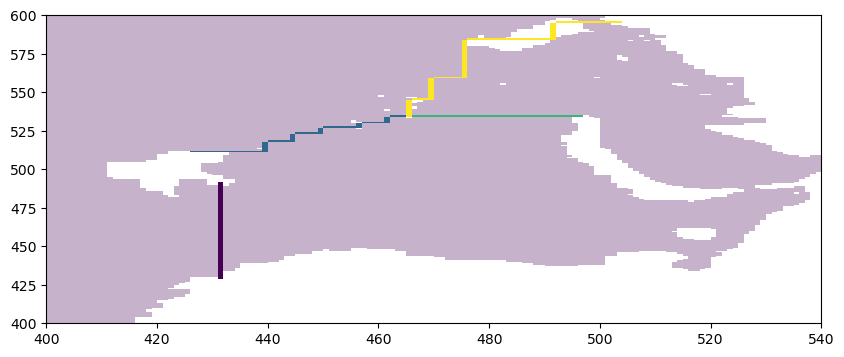

In [15]:
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0],alpha=0.3)
plt.pcolormesh(get_aste_tracer(test,nfx,nfy)[0])
plt.xlim(400,540)
plt.ylim(400,600)

In [16]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations

In [17]:
xs = np.array([x_bso,x_sfj,x_fjnz,x_sta_vilkit],dtype="object")
ys = np.array([y_bso,y_sfj,y_fjnz,y_sta_vilkit],dtype="object")

# Calculate the J_x and J_y terms

In [18]:
# set months here just to be sure
m = 0   # for the snaps in datetimes
s = 2   # for the snaps in datetimes
m_avg = 0  # for the averages in tendency
s_avg = 1  # for the averages in tendency

# the following is how we did it before but we only want to do this for the gates, not the whole basin
# steps
    # get a mask from test for the gate we want (tmpmask)
    # multiply G_S[month] * tmpmask
    # create J terms from this


# SYNTAX for whole arctic:
# calc for first month
# J_x_vec_m1 = calc_G_term(G_S[m_avg],binned_theta[m],binned_salinity[m],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC
# J_y_vec_m1 = calc_G_term(G_T[m_avg],binned_theta[m],binned_salinity[m],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU

# calc for second month
# J_x_vec_m2 = calc_G_term(G_S[s_avg],binned_theta[s],binned_salinity[s],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC
# J_y_vec_m2 = calc_G_term(G_T[s_avg],binned_theta[s],binned_salinity[s],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU

# do a sample gateway as a TS mesh

In [19]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',31).copy()
# cmap = plt.get_cmap('rainbow',31).copy()
cmap.set_under(color='white')
cmap_bath = plt.get_cmap('Blues',31).copy()

# try to loop and plot distr for all gates

In [36]:
time = s   # month so we can run it in next block
s

2

In [37]:
Uomeancompact = aste_tracer2compact(Uo[time],nfx,nfy)
Vomeancompact = aste_tracer2compact(Vo[time],nfx,nfy)   # should rename these after we make sure this runs

In [38]:
binned_theta_tmean = binned_theta[time]
binned_salinity_tmean = binned_salinity[time]

In [39]:
# tmpmask = np.full(Uomeancompact.shape,0)
# tmpmask[:,y_bso,x_bso] = 1
# G_S_sel = G_S[time] * tmpmask
# G_T_sel = G_T[time] * tmpmask
# J_x_vec = calc_G_term(G_S_sel,binned_theta[time],binned_salinity[time],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC
# J_y_vec = calc_G_term(G_T_sel,binned_theta[time],binned_salinity[time],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU


1
2
3
4


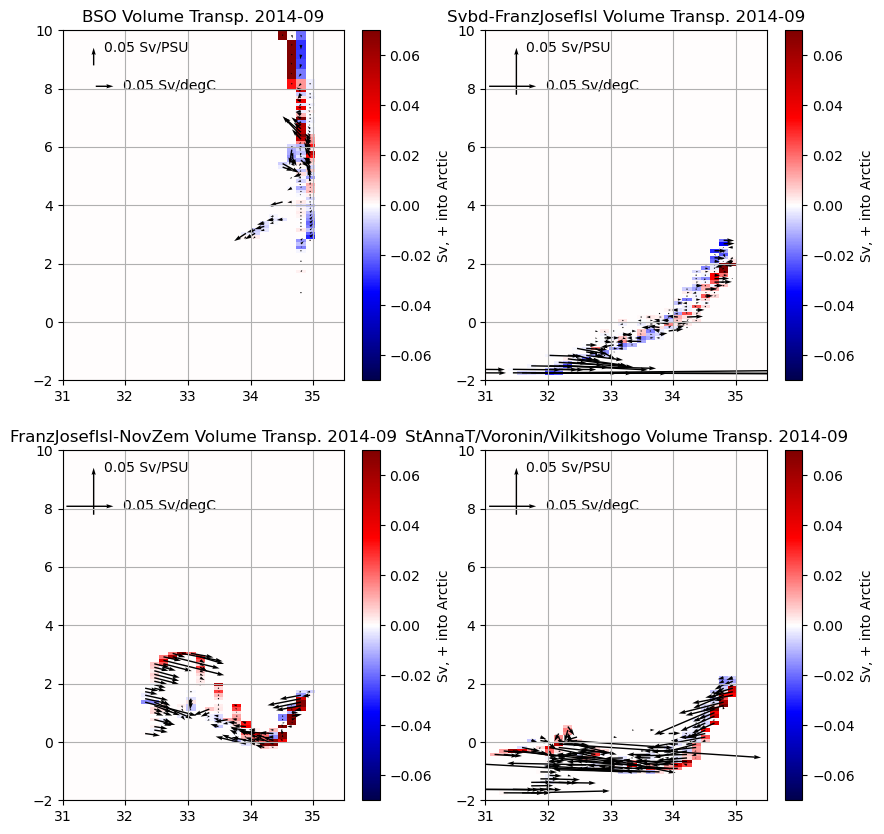

In [41]:
gateids = np.array([1,2,3,4])
names = np.array(["BSO","Svbd-FranzJosefIsl","FranzJosefIsl-NovZem","StAnnaT/Voronin/Vilkitshogo"])

# loop through each of the gates
fig = plt.figure(figsize=(10,10))
totaldistr = np.full((nT,nS),0.0)
step = 1
scale1 = .8
scale2 = .3
U1 = .1
U2 = .05

for x_curr, y_curr,gateid,name in zip(xs,ys,gateids,names):
    ######
    # first we calculate the volume transport for the month of interest
    print(gateid)
    ax = plt.subplot(2,2,gateid)

    # get the u and v components
    uvelgate = Uomeancompact[:,y_curr,x_curr]
    vvelgate = Vomeancompact[:,y_curr,x_curr]
    
    # get the perpendicular vel
    choose_UV = line_orientation(y_curr,x_curr)
    choose_UV = np.tile(choose_UV,(nz,1))
    
    # calculate transport velocity
    perpendicular_vel = np.full(uvelgate.shape,np.nan) #    zeros_like(uvelgate)
    for i in range(len(choose_UV)):
        if choose_UV[i][0] == "V":
            perpendicular_vel[i] = uvelgate[i]       # remember to think about proper sign
        elif choose_UV[i][0] == "H":
            perpendicular_vel[i] = vvelgate[i]
            
    #print(uvelgate.shape, vvelgate.shape, choose_UV.shape, perpendicular_vel.shape)
    
    # calculate cell area
    gatemask = mygrid['hFacC'][:,y_curr,x_curr]
    dxggate = mygrid['DXG'][y_curr,x_curr]
    dyggate = mygrid['DYG'][y_curr,x_curr]
    cell_lengths = np.full(choose_UV[0].shape[0],np.nan)
    for i in range(len(choose_UV[0])):
        if choose_UV[0][i] == "V":
            cell_lengths[i] = dyggate[i] #DYG
        elif choose_UV[0][i] == "H":
            cell_lengths[i] = dxggate[i] #DXG
    cell_lengths = np.tile(cell_lengths,(nz,1))
    cell_area = cell_lengths * mygrid['DRF'].reshape(nz,1)
    
    # calculate binned S and T
    binned_theta_gate = binned_theta_tmean[:,y_curr,x_curr]
    binned_salinity_gate = binned_salinity_tmean[:,y_curr,x_curr]
    
    data = perpendicular_vel*cell_area*1e-6
    
    # data is now the volume transport at the gate, we can bin this with the TS at the gate and plot
    gate_thetabins = binned_theta_tmean[:,y_curr,x_curr]
    gate_saltbins = binned_salinity_tmean[:,y_curr,x_curr]
    
    # get the distribution of volume in TS space
    distr = np.full((nT,nS),0.0)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not np.isnan(gate_thetabins[i,j]):
                distr[int(gate_saltbins[i,j]),int(gate_thetabins[i,j])] += data[i,j]

    totaldistr += distr

    ##################
    # now calculate the J terms
    # steps
    # get a mask from test for the gate we want (tmpmask)
    # multiply G_S[month] * tmpmask
    # create J terms from this

    # SYNTAX for whole arctic:
    # calc for first month
    # J_x_vec_m1 = calc_G_term(G_S[m_avg],binned_theta[m],binned_salinity[m],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC
    # J_y_vec_m1 = calc_G_term(G_T[m_avg],binned_theta[m],binned_salinity[m],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU

    tmpmask = np.full(Uomeancompact.shape,0)
    tmpmask[:,y_curr,x_curr] = 1
    G_S_sel = G_S[1] * tmpmask
    G_T_sel = G_T[1] * tmpmask
    J_x_vec = calc_G_term(G_S_sel,binned_theta[time],binned_salinity[time],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC
    J_y_vec = calc_G_term(G_T_sel,binned_theta[time],binned_salinity[time],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU
    
    ###################
    # now plot
    cb = ax.pcolormesh(Sbin,Tbin,distr,cmap='seismic',vmin=-.07,vmax=.07)
    U1, V1 = J_x_vec,J_y_vec/16
    if gateid == 1:
        q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale1)
        
    else:
        q1 = ax.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale2)

    # write the quiver keys
    ax.quiverkey(q1, X=0.18, Y=0.84, U=U2, label=str(U2) + " Sv/degC", labelpos='E')
    ax.quiverkey(q1, X=0.11, Y=0.95, U=U2, label=str(U2) + " Sv/PSU", labelpos='E',angle = 90)
    
    # set other labels
    ax.set_ylim(-2,10)
    ax.set_xlim(31,35.5)
    ax.set_title(name+" Volume Transp. " + datetimes[time].strftime("%Y-%m"))
    plt.colorbar(cb,label="Sv, + into Arctic")
    ax.grid()

plt.savefig(path + "fourgates_TSdist_with_J_sept.png",dpi=300)

In [ ]:
np.nanmax(U1)

In [ ]:
fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)

cb = ax.pcolormesh(Sbin,Tbin,totaldistr,cmap=cmap,vmin=-.1,vmax=.1)
ax.set_ylim(-2,8.5)
ax.set_xlim(31,35.5)
ax.set_title("All Gates Volume Avg 2014")
plt.colorbar(cb,label="Sv, + into Arctic")
ax.grid()

# plt.savefig(path + "pemberton_fig11_total.png",dpi=300)

In [ ]:
# now plot this on top of the volume distribution totals
fig = plt.figure(figsize = (8,6))
ax = plt.subplot(111)

cb = ax.pcolormesh(Sbin,Tbin,totaldistr,cmap=cmap,vmin=-.1,vmax=.1)
ax.set_ylim(-2,8.5)
ax.set_xlim(31,35.5)
ax.set_title("All Gates Volume Avg with Advection, 2014")
plt.colorbar(cb,label="Sv, + into Arctic")
quiver_plot = plt.quiver(Sbincent,Tbincent,tot_dist_slt,tot_dist_th,scale=500000000)

# Add a quiver key (reference arrow)
scale_arrow_magnitude = 1e7  # Adjust this value based on your data's scale
plt.quiverkey(quiver_plot, X=0.1, Y=0.9, U=scale_arrow_magnitude, label=f'{scale_arrow_magnitude} m^3/s', labelpos='E')

ax.grid()

plt.savefig(path + "pemberton_fig12.png",dpi=300)